# Compute persistence and climatology scores for benchmark

In [82]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from src.score import *

In [84]:
sns.set_style('darkgrid')
sns.set_context('notebook')

In [85]:
DATADIR = '/data/weather-benchmark/5.625deg/geopotential_500/'

In [86]:
!ls $DATADIR

geopotential_500_1979_5.625deg.nc  geopotential_500_1999_5.625deg.nc
geopotential_500_1980_5.625deg.nc  geopotential_500_2000_5.625deg.nc
geopotential_500_1981_5.625deg.nc  geopotential_500_2001_5.625deg.nc
geopotential_500_1982_5.625deg.nc  geopotential_500_2002_5.625deg.nc
geopotential_500_1983_5.625deg.nc  geopotential_500_2003_5.625deg.nc
geopotential_500_1984_5.625deg.nc  geopotential_500_2004_5.625deg.nc
geopotential_500_1985_5.625deg.nc  geopotential_500_2005_5.625deg.nc
geopotential_500_1986_5.625deg.nc  geopotential_500_2006_5.625deg.nc
geopotential_500_1987_5.625deg.nc  geopotential_500_2007_5.625deg.nc
geopotential_500_1988_5.625deg.nc  geopotential_500_2008_5.625deg.nc
geopotential_500_1989_5.625deg.nc  geopotential_500_2009_5.625deg.nc
geopotential_500_1990_5.625deg.nc  geopotential_500_2010_5.625deg.nc
geopotential_500_1991_5.625deg.nc  geopotential_500_2011_5.625deg.nc
geopotential_500_1992_5.625deg.nc  geopotential_500_2012_5.625deg.nc
geopotential_500_1993_5.625deg.nc 

In [87]:
z500 = xr.open_mfdataset(f'{DATADIR}*').z

In [88]:
z500

<xarray.DataArray 'z' (time: 350640, lat: 33, lon: 64)>
dask.array<shape=(350640, 33, 64), dtype=float32, chunksize=(8760, 33, 64)>
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -90.0 -84.38 -78.75 -73.12 ... 73.12 78.75 84.38 90.0
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
Attributes:
    units:          m**2 s**-2
    long_name:      Geopotential
    standard_name:  geopotential

## Persistence

In [89]:
z500_validation = z500.sel(time=slice('2017', '2018'))

In [90]:
z500_validation

<xarray.DataArray 'z' (time: 17520, lat: 33, lon: 64)>
dask.array<shape=(17520, 33, 64), dtype=float32, chunksize=(8760, 33, 64)>
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -90.0 -84.38 -78.75 -73.12 ... 73.12 78.75 84.38 90.0
  * time     (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00
Attributes:
    units:          m**2 s**-2
    long_name:      Geopotential
    standard_name:  geopotential

In [91]:
def create_persistence_forecast(da, lead_time_h):
    assert lead_time_h > 0, 'Lead time must be greater than 0'
    da_fc = da.isel(time=slice(0, -lead_time_h))
    da_fc['time'] = da_fc.time + np.timedelta64(lead_time_h, 'h')
    return da_fc

In [95]:
scores = []
lead_times = np.arange(1, 121, 1)
for lead_time_h in lead_times:
    rmse = compute_weighted_rmse(
        create_persistence_forecast(z500_validation, lead_time_h), z500_validation
    ).values
    scores.append(rmse)

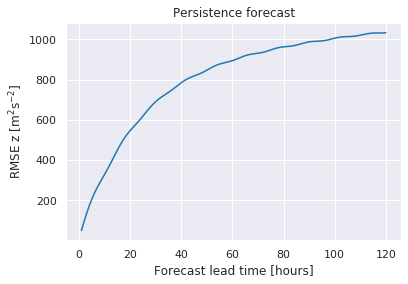

In [96]:
plt.plot(lead_times, scores)
plt.ylabel(r'RMSE z [m$^2$s$^{-2}$]')
plt.xlabel('Forecast lead time [hours]')
plt.title('Persistence forecast');

In [98]:
compute_weighted_rmse(
    create_persistence_forecast(z500_validation, 3*24), z500_validation
).values

array(935.81711507)

In [99]:
compute_weighted_rmse(
    create_persistence_forecast(z500_validation, 5*24), z500_validation
).values

array(1033.05221607)

## Climatology

In [100]:
def create_climatology_forecast(da_train):
    return da_train.mean('time')

In [101]:
z500_train = z500.sel(time=slice(None, '2016'))

In [102]:
fc = create_climatology_forecast(z500_train)

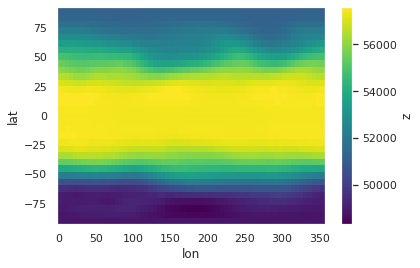

In [104]:
fc.plot();

In [106]:
compute_weighted_rmse(fc, z500_validation).values

array(1074.85560374)

In [121]:
def create_weekly_climatology_forecast(da_train, valid_time):
    da_train['week'] = da_train['time.week']
    weekly_averages = da_train.groupby('week').mean('time')
    valid_time['week'] = valid_time['time.week']
    fc_list = []
    for t in valid_time:
        fc_list.append(weekly_averages.sel(week=t.week))
    return xr.concat(fc_list, dim=valid_time)

In [122]:
fc = create_weekly_climatology_forecast(z500_train, z500_validation.time)

In [123]:
fc

<xarray.DataArray 'z' (time: 17520, lat: 33, lon: 64)>
dask.array<shape=(17520, 33, 64), dtype=float32, chunksize=(1, 33, 64)>
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -90.0 -84.38 -78.75 -73.12 ... 73.12 78.75 84.38 90.0
    week     (time) int64 52 52 52 52 52 52 52 52 52 52 ... 1 1 1 1 1 1 1 1 1 1
  * time     (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00

In [126]:
compute_weighted_rmse(fc, z500_validation).values

array(815.39207)

The End